# Deep Learning for Computer Vision:  HW 4

## Computer Science: COMS W 4995 006

### Due: November 1, 2022

### Problem

1. In this notebook we provide three networks for classifying handwritten digits from the MNIST dataset. The networks are implemented and tested using the Tensorflow framework. The third and final network is a convolutional neural network (CNN aka ConvNet) which achieves 99.18% accuracy on this dataset. 

    Your task is to re-implement all three networks using Pytorch. You will likely find several Pytorch implementations on the internet. It is ok to study these. However, you must not cut and paste this code into your assignment--you must write this yourself. Furthermore, you need to comment every line of code and succintly explain what it is doing! 

    Here is what is required:

    a) A FULLY commented re-implementation of the networks below using Pytorch.

    b) your network trained on the same MNIST data as used here.

    c) an evaluation of the accuracy on the MNIST test set.

    d) plots of 10 randomly selected digits from the test set along with the correct label and the assigned label.

    e) have your training record a log of the validation loss and validation accuracy. 

    f) have your training continually save the best model so far (as determined by the validation loss).

    g) after training, load the saved weights using the best model so far. re-run you accuracy evaluation using these saved weights.

    Below we include the Tensorflow examples shown in class.  
   <p>&nbsp;</p> 

2. (EXTRA CREDIT): Redo Problem 1 coding up your network in JAX. You must write the code yourself. This problem is extra credit and you are on your own if you decide to try this. Please do not ask the professor or the TAs on how to do this. Write a paragraph commenting on your experience with JAX.
<p>&nbsp;</p> 

3. (EXTRA CREDIT): Redo Problem 1 coding up your network in Flashlight. You must write the code yourself. This problem is extra credit and you are on your own if you decide to try this. Please do not ask the professor or the TAs on how to do this. Write a paragraph commenting on your experience with Flashlight.

### A Simple Convolutional Neural Network in Tensorflow

This notebook covers a python and tensorflow-based solution to the handwritten digits recognition problem. It is based on tensorflow tutorials and Yann LeCun's early work on CNN's. This toturial compares a simple softmax regressor, a multi-layer perceptron (MLP), and a simple convolutional neural network (CNN).

Load in the MNIST digit dataset directly from tensorflow examples.

In [14]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

ModuleNotFoundError: No module named 'tensorflow.examples'

The MNIST data is split into three parts: 55,000 data points of training data (mnist.train), 10,000 points of test data (mnist.test), and 5,000 points of validation data (mnist.validation). 

Let's import tensorflow and begin an interactive session.

In [ ]:
import tensorflow as tf
sess = tf.InteractiveSession()

## Softmax Regression Model on the MNIST Digits Data

We need to create placeholders for the data. Data will be dumped here when it is batched from the MNIST dataset.

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

Now let's see what this data looks like.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(4):
    batch = mnist.test.next_batch(1)
    image = np.asarray(batch[0]).reshape((28, 28))
    label = batch[1]
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()

We are first going to do softmax logistic regression. This is a linear layer followed by softmax. Note there are NO hidden layers here. Also note that the digit images (28x28 grayscale images) are reshaped into a 784 element vector. 

Below we create the parameters (weights) for our linear layer.

In [ ]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

We then use tensorflows initializer to initialize these weights.

In [ ]:
sess.run(tf.global_variables_initializer())

We create our linear layer as a function of the input and the weights.

In [ ]:
y_regressor = tf.matmul(x,W) + b

Below we create our loss function. Note that the cross entropy is $ H_{\hat{y}}(y) = -\sum_i \hat{y}_{i} \, \log(y_{i})$ where $\hat{y}$ is the true probability distribution and is expressed as a one-hot vector, $y$ is the estimated probability distribution, and $i$ indexes elements of these two vectors. Also note that this reduces to $ H_{\hat{y}}(y) = -\, \log(y_{i^*})$ where $i^*$ is the correct label. And if we sum this over all of our samples indexed by $j$, then $H_{\hat{y}}(y) = -\sum_j  \log(y^{(j)}_{i^*})$. This is precisely the same loss function as we used before, but we called the MLE loss. They are one and the same.

In [ ]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_regressor))

Now we tell tf to use gradient descent with a step size of 0.5 and to minimize the cross entropy.

In [ ]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

We train by grabbing mini-batches with 100 samples each and pushing these through the network to update our weights (W and b).

In [ ]:
for _ in range(1000):
  batch = mnist.train.next_batch(100)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

We define how to compute correct predicitions.

In [ ]:
correct_prediction = tf.equal(tf.argmax(y_regressor,1), tf.argmax(y_,1))

And from these correct predictions how to compute the accuracy.

In [ ]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

Let's print out some test images and the corresponsing predictions made by the network. But first, let's add an output to the computation graph that computes the softmax probabilities.

In [ ]:
y_probs_regressor = tf.nn.softmax(logits=y_regressor, name=None)

In [ ]:
for i in range(5):
    batch = mnist.test.next_batch(1)
    image = np.asarray(batch[0]).reshape((28, 28))
    label = batch[1]
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print "Label = ", label
    print "Class probabilities = ", y_probs_regressor.eval(feed_dict={
        x: batch[0], y_: batch[1]})

## Softmax Multi-Layer Perceptron on the MNIST Digits Data

Here we define both weight and bias variables and how they are to be initialized. Note that the weights are are distributed according to a standard normal distribution (mean = 0, std = 0.1). This random initialization helps avoid hidden units get stuck together, as units that start with the same value will be updated identically in the non-convolutional layers. In contrast, the bias variables are set to a small positive number--this is help prevent hidden units from starting out and getting stuck in the zero part of the ReLU. 

In [ ]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

Next we create placeholders for the training data.

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

We create the first and only fully connected hidden layer.

In [ ]:
W_h = weight_variable([784, 512])
b_h = bias_variable([512])
h = tf.nn.relu(tf.matmul(x, W_h) + b_h)

We create the output layer.

In [ ]:
W_out = weight_variable([512, 10])
b_out = bias_variable([10])
y_MLP = tf.matmul(h, W_out) + b_out

We again use cross entropy loss on a softmax distribution on the outputs.

In [ ]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_MLP))

For training we choose an Adam learning rate and update rule. We then run this for 20,000 iterations and evaluate our accuracy after training. Note this softmax MLP network does quite a bit bettter than our softmax regressor. The non-linear layer really helps makes sense of the data! But we can do better still...

In [ ]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_MLP,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%1000 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1]})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels}))

## A Simple Convolutional Neural Network: LeNet

Here we make our first CNN. It's quite simple network, but it's surprisingly good at this handwritten digit recognition task. This a variant on Yann LeCun's CNN network that really helped to move deep learning forward.

We define both weight and bias variables and how they are to be initialized. Note that the weights are are distributed according to a standard normal distribution (mean = 0, std = 0.1). This random initialization helps avoid hidden units get stuck together, as units that start with the same value will be updated identically in the non-convolutional layers. In contrast, the bias variables are set to a small positive number--this is help prevent hidden units from starting out and getting stuck in the zero part of the ReLu. 

In [ ]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

Next we define how the convolution is to be computed and the extent and type of pooling. The convolution will use a 5x5 kernel and will pad the image with zeros around the edges and use a stride of 1 pixel so that the resulting image (after convolution) has the same size as the original input image. The network will learn the weights for a stack of 32 separate kernels along with 32 bias variables. Finally, after the ReLu is performed the result will be under go 2x2 max pooling, thus halfing both dimensions of the image. The choices for the stride, padding, and pooling are not parameters that the network needs to estimate. Rather these are termed "hyperparamters" that are usually set by the network designer.

In [ ]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

This creates the weight and bias variables for the first convolutional layer as described above. Note the output has depth 32, so there will be 32 feature images after this layer.

In [ ]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

Unlike for our softmax regressor above, here we need keep the images as images and not collapse these into vectors; this allows us to perform the 2D convolution.

In [ ]:
x_image = tf.reshape(x, [-1,28,28,1])

Finally, we define are first layer of our CNN!

In [ ]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

And wasting no time, we define are second layer. The second layer will have to process 32 feature images coming out of the first layer. Note that the images input to this layer have $\frac{1}{4}$ the number of pixels as the original input images due to the 2x2 pooling in the previous layer. Note that convolution layer NOT fully connected as our previous hidden layers have been. A unit in the output layer has a limited "receptive field." Its connections to the input layer are spatially limited by the kernel (or filter) size. Also, because of weight sharing in convolutional layers, the number of parameters for a convolutional is the size of the kernel x the depth of the input layer x depth of the output layer + depth of the output layer. So for the second layer of our ConvNet, we have 5 x 5 x 32 x 64 + 64 = 51,264 parameters. 

In [ ]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

After the pooling stage of our second convolutional layer, we have 64 7x7 "feature" images. In one penultimate fully connected hidden layer, we are going to map these feature imges to a 1024 dimensional feature space. Note we need to flatten these feature images to do this.

In [ ]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

Dropout is added here, although it is not really needed for such small network.

In [ ]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

We have a final linear output layer mapping features to scores topped off with a softmax cross entropy loss function, as explained earlier.

In [ ]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [ ]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

For training we choose an Adam learning rate and update rule. We then run this for 20,000 iterations and evaluate our accuracy after training.

In [ ]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%1000 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

We add an output to compuational graph that computes the label probabilities.

In [ ]:
y_probs = tf.nn.softmax(logits=y_conv, name=None)

In [ ]:
print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Next we step through some test examples and see how well the network is doing.

In [ ]:
for i in range(5):
    batch = mnist.test.next_batch(1)
    image = np.asarray(batch[0]).reshape((28, 28))
    label = batch[1]
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print "Label = ", label
    print "Class probabilities = ", y_probs.eval(feed_dict={
        x: batch[0], y_: batch[1], keep_prob: 1.0})

## 1) A FULLY commented re-implementation of the networks below using Pytorch.

In [18]:
# Import modules required
import sys
!{sys.executable} -m pip install torch torchvision
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

In [19]:
# Obtain data sets available in torch vision
train_data = datasets.MNIST(root = 'data',train = True, transform = ToTensor(), download = True)
nontrained_data = datasets.MNIST(root = 'data', train = False, transform = ToTensor())

# Split nontrained data up into validation & test data (randomly)
validation_data, test_data = torch.utils.data.random_split(nontrained_data, [5000, 5000])

In [20]:
print("Training data:")
print(train_data)
print("\nUntrained data (validation + test):")
print(nontrained_data)
print("\nValidation data:")
print(validation_data)
print("\nTest data:")
print(test_data)

Training data:
Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Untrained data (validation + test):
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

Validation data:

Test data:


In [21]:
# Define all types of data being used here
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'untrained'  : torch.utils.data.DataLoader(nontrained_data, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'validation'  : torch.utils.data.DataLoader(validation_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=50,
                                          shuffle=True, 
                                          num_workers=1),
}
loaders
type(test_data)

torch.utils.data.dataset.Subset

In [22]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Layer #1
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=32,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        
        # Layer #2
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,              
                out_channels=64,            
                kernel_size=5,              
                stride=1,                   
                padding=2,
            ),     
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),                
        )
        
        # Layer #3: Fully connected layer (flattened first), output 10 possible classes
        self.out = nn.Linear(7 * 7 * 64, 10)
    def forward(self, x):
        # Put through 2 convolution layers
        x = self.conv1(x)
        x = self.conv2(x)
        
        
        # Fully flatten before output layer
        x = x.view(x.size(0), -1)       
        
        # Output layer
        output = self.out(x)
        return output, x    # return x for visualization

In [23]:
# Define convolutional NN
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=3136, out_features=10, bias=True)
)


In [24]:
# Define loss function to be used for updates
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [25]:
# How to update model (optimizer)
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

Initial accuracy: 0.09
Epoch [1/10], Step [100/600], Loss: 0.2425
Epoch [1/10], Step [200/600], Loss: 0.0737
Epoch [1/10], Step [300/600], Loss: 0.2649
Epoch [1/10], Step [400/600], Loss: 0.1376
Epoch [1/10], Step [500/600], Loss: 0.1018
Epoch [1/10], Step [600/600], Loss: 0.0932
Epoch [2/10], Step [100/600], Loss: 0.0722
Epoch [2/10], Step [200/600], Loss: 0.1415
Epoch [2/10], Step [300/600], Loss: 0.0916
Epoch [2/10], Step [400/600], Loss: 0.1968
Epoch [2/10], Step [500/600], Loss: 0.1007
Epoch [2/10], Step [600/600], Loss: 0.0401
Epoch [3/10], Step [100/600], Loss: 0.0189
Epoch [3/10], Step [200/600], Loss: 0.0870
Epoch [3/10], Step [300/600], Loss: 0.0329
Epoch [3/10], Step [400/600], Loss: 0.0725
Epoch [3/10], Step [500/600], Loss: 0.0422
Epoch [3/10], Step [600/600], Loss: 0.0324
Epoch [4/10], Step [100/600], Loss: 0.0549
Epoch [4/10], Step [200/600], Loss: 0.1378
Epoch [4/10], Step [300/600], Loss: 0.1393
Epoch [4/10], Step [400/600], Loss: 0.0436
Epoch [4/10], Step [500/600], L

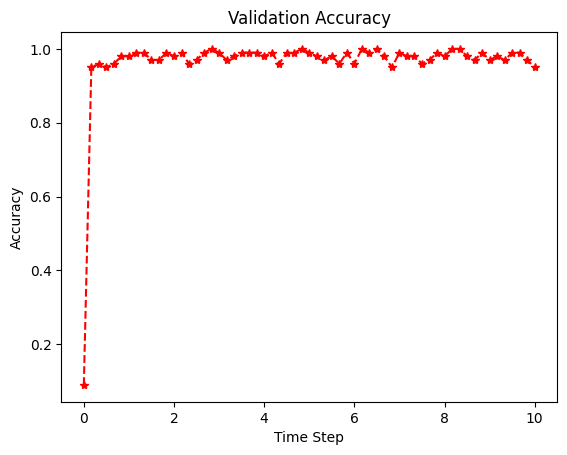

In [26]:
# Train model
from torch.autograd import Variable
import copy
    
def validate():
    # Validate the model
    
    # Turn off training equipment
    cnn.eval()
    
    # Iterate with no gradient updates
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['validation']:
            # Test & predict data
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
    
    # Calculate & return accuracy
    accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    return accuracy

# Define number of epochs being used
num_epochs = 10

# Define the validation vectors/save data
accuracies = [validate()]
print("Initial accuracy:",accuracies[0])
times = [0]
losses = [1] # first loss is not valid
copies = [copy.deepcopy(cnn)]

def train(num_epochs, cnn, loaders):
    
    # Turn model on for training
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # get next batch data
            b_x = Variable(images)   
            b_y = Variable(labels) 
            
            # throw through forward prop
            output = cnn(b_x)[0] 
            
            # get loss
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation using the selected loss function
            loss.backward()    
            
            # apply optimization & gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                
                # Validate model
                accuracies.append(validate())
                losses.append(loss)
                times.append(epoch + (i+1)/total_step)
                copies.append(copy.deepcopy(cnn))
    
    # Plot validation curve
    plt.figure()
    plt.title("Validation Accuracy")
    plt.xlabel("Time Step")
    plt.ylabel("Accuracy")
    plt.plot(times,accuracies,'r*--')
    plt.show()
    
#     plt.figure()
#     plt.title("Test Loss")
#     plt.xlabel("Time Step")
#     plt.ylabel("Loss")
#     plt.plot(times[1:],losses[1:],'r*--')
#     plt.show()

train(num_epochs, cnn, loaders)

In [27]:
# Change CNN to early model with little error from validation data
cnn = copies[4]
    

def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            # Throw images through the CNN
            test_output, last_layer = cnn(images)
            
            # Predict what y will be based on highest output probability
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
    
    # Get the net accuracy
    accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    print('Test Accuracy: %.2f' % accuracy)

test()

Test Accuracy: 0.98


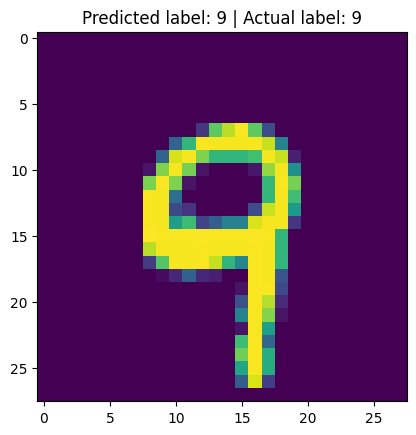

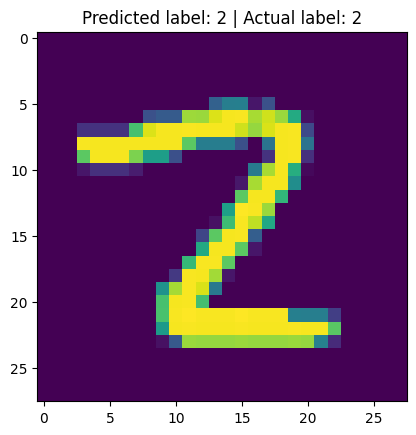

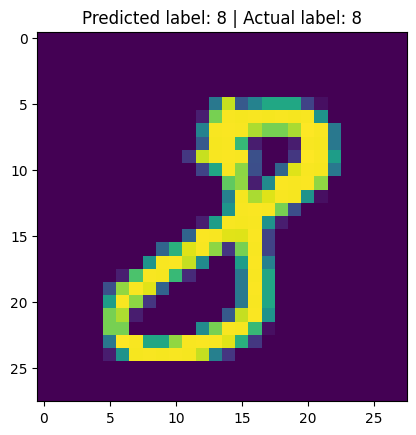

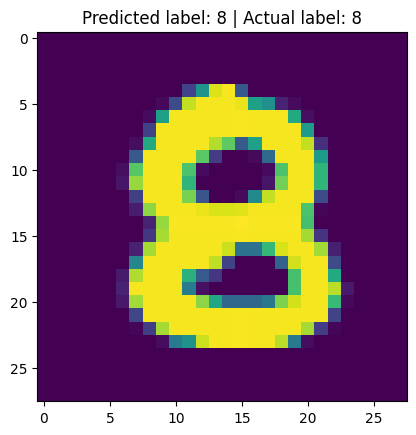

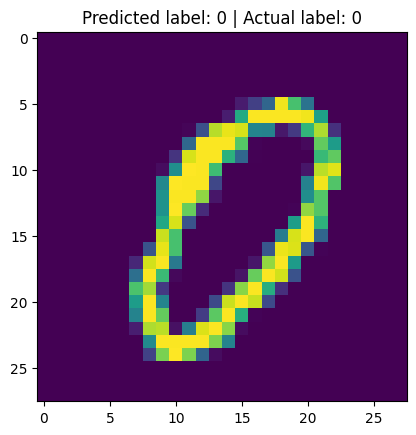

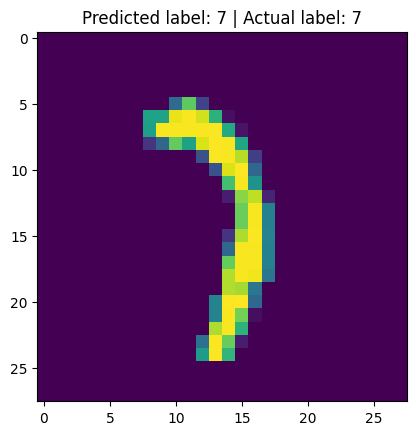

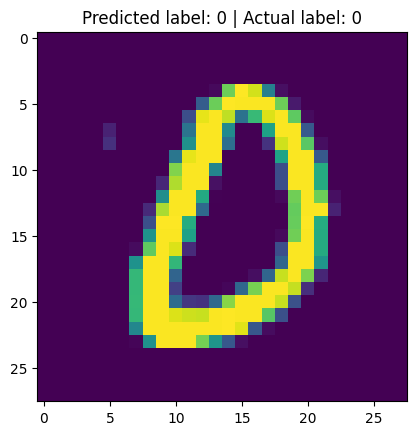

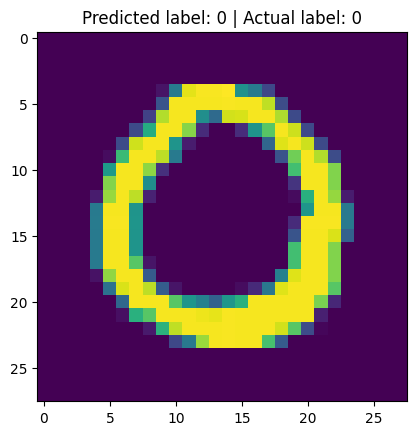

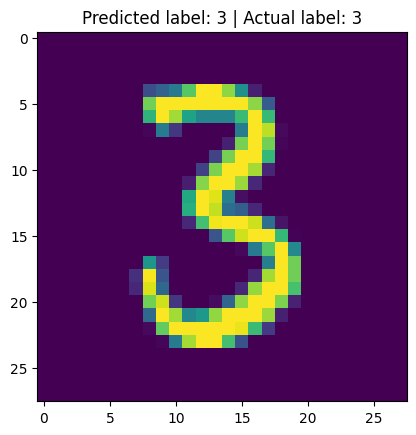

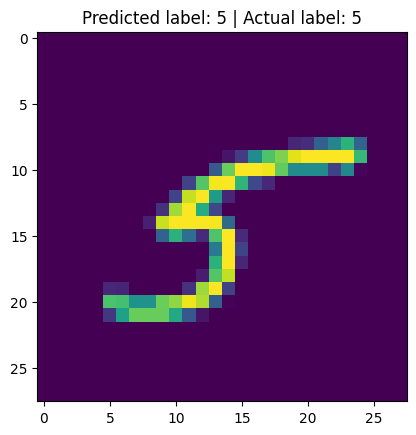

In [28]:
# Show 10 samples from the test data
pointsToShow = test_data.indices[0:10]
for i, (images, labels) in enumerate(loaders['untrained']):
    if i not in pointsToShow:
        continue
    
    plt.figure()
    plt.imshow(images[0][0])
    test_output, last_layer = cnn(images)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    plt.title('Predicted label: %i | Actual label: %i' % (pred_y,labels[0]))
    plt.show()

### 2) A FULLY commented re-implementation of the networks below using JAX

In [ ]:
# import sys
# !{sys.executable} -m pip uninstall jax jaxlib
# !{sys.executable} -m y
# !{sys.executable} -m pip install --upgrade "jax[cpu]"
# import jax.numpy as jnp
# from jax import grad, jit, vmap
# from jax import random

In [ ]:
# # Randomly initialize weights and biases for NN
# def random_layer_params(m, n, key, scale=1e-2):
#   w_key, b_key = random.split(key)
#   return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# # Layer instantiation
# def init_network_params(sizes, key):
#   keys = random.split(key, len(sizes))
#   return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

# layer_sizes = [784, 196, 49, 10]
# step_size = 0.01
# num_epochs = 10
# batch_size = 100
# n_targets = 10
# params = init_network_params(layer_sizes, random.PRNGKey(0))

In [ ]:
# Ignore attempted JAX implementation above, JAX is not installing correctly and stackoverflow wont help